In [1]:
import cv2 as cv
import sys
import numpy as np
import matplotlib.pyplot as plt


# Read, Write, and Show

Keep in mind to add 'cv.destroyAllWindows()' to close opencv windows. 

Closing a window by red cross will make Jupyter notebook crash (describe [here](https://medium.com/@mrdatainsight/how-to-use-opencv-imshow-in-a-jupyter-notebook-quick-tip-ce83fa32b5ad)).

In [34]:
def imshow(title, image, also_plot_with_pyplot=True):
    """Wrapper for cv.imshow

    Args:
        title (str): title for the display window
        image (cv Mat object): image to show

    Returns:
        str: the key pressed in the image display window
    """
    cv.imshow(title, image)
    input_key = cv.waitKey(0)
    cv.destroyAllWindows()
    if also_plot_with_pyplot:
        if len(image.shape) <= 2:
            plt.imshow(cv.cvtColor(image, cv.COLOR_GRAY2RGB))
        else:
            plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    return chr(input_key)

def stack_images(images, vertical_or_horizontal='h'): 
    images_3channel = []
    for image in images:
        if len(image.shape) <= 2:
            tmp = cv.cvtColor(image, cv.COLOR_GRAY2BGR)
        else:
            tmp = image
        images_3channel.append(tmp)
        
    if vertical_or_horizontal == 'h':
        return np.hstack(tuple(images_3channel))
    elif vertical_or_horizontal == 'v':
        return np.vstack(tuple(images_3channel))


Read, write and show a test image.

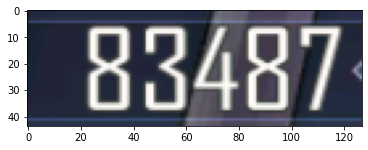

In [36]:
image_file_name = 'image/image_83487.png'
image = cv.imread(image_file_name, )
if image is None:
    sys.exit(f'Fail to read the image: {image_file_name}')

input_key = imshow('test', image)

if input_key == 's': # save
    image_save_file_name = 'test.png'
    cv.imwrite(image_save_file_name, image)

# Boxing Numbers

Transform from a color image to a binary image.

Note that background should be black and target should be white for contour calculation involved in boxing.

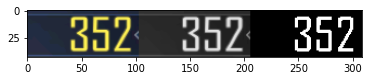

In [61]:
image_file_name = 'image/image_352.png'
threshold = 140
maxvalue = 255

image_color = cv.imread(image_file_name, cv.IMREAD_COLOR)
image_gray = cv.cvtColor(image_color, cv.COLOR_BGR2GRAY)
image_threshold = cv.threshold(image_gray, threshold, maxvalue, cv.THRESH_BINARY)[1]
#image_binary = cv.bitwise_not(image_threshold) # invert black and white
image_binary = image_threshold

input_key = imshow('gray image', stack_two_images([image_color, image_gray, image_binary]))
plt.imshow(cv.cvtColor(stack_images([image_color, image_gray, image_binary]), cv.COLOR_BGR2RGB))


Calculate the bounding box for the whole image (just for test)

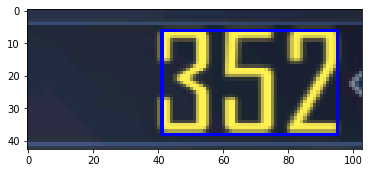

In [65]:
x1, y1, w, h = cv.boundingRect(image_binary)
x2 = x1 + w
y2 = y1 + h

box_line_thickness = 1
box_line_color = (255, 0, 0)
image_with_box = image_color.copy()
cv.rectangle(image_with_box, (x1, y1), (x2, y2), box_line_color, box_line_thickness)
key = imshow('Original Image with the Bounding Box', image_with_box)

Calculate contours and get the bounding boxes for each digit

Found 3 contours(s)
Contour 0: from (81, 6) to (95, 38)
Contour 1: from (61, 6) to (75, 38)
Contour 2: from (41, 6) to (56, 38)


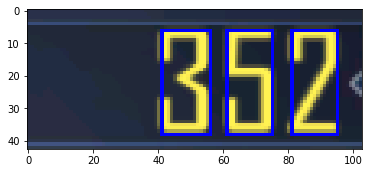

In [64]:
contours, hierachy = cv.findContours(image_binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
image_with_box = image_color.copy()
print(f'Found {len(contours)} contours(s)')
for i, contour in enumerate(contours):
    x1, y1, w, h = cv.boundingRect(contour)
    x2 = x1 + w
    y2 = y1 + h
    cv.rectangle(image_with_box, (x1, y1), (x2, y2), box_line_color, box_line_thickness)
    print(f'Contour {i}: from ({x1}, {y1}) to ({x2}, {y2})')
key = imshow('Original Image with the Bounding Box', image_with_box)

Save images for each digits

# Reference
[Opencv tutorial: creating bounding boxes](https://docs.opencv.org/3.4/da/d0c/tutorial_bounding_rects_circles.html)